# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
import warnings
warnings.simplefilter('ignore')
from tensorflow.keras import layers
from tensorflow import feature_column
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential
from keras import layers
import tensorflow as tf
import os
import zipfile
from tqdm import tqdm

# Loading Data

In [2]:
curdir = os.getcwd()
DATA_DIR = f'{curdir}/Data'
TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'
OUTPUT_DIR = f'{DATA_DIR}/output'

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
    if not os.path.exists(pth):
        os.makedirs(pth)

In [3]:
train_zip = "train.zip"
test_zip = "test.zip"
sample_sub = "SampleSubmission.csv"
with zipfile.ZipFile(f'{TRAIN_DIR}/train.zip', 'r') as zip_ref:
    zip_ref.extractall(TRAIN_DIR)
with zipfile.ZipFile(f'{TEST_DIR}/test.zip', 'r') as zip_ref:
        zip_ref.extractall(TEST_DIR)

In [4]:
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv', low_memory=False, index_col = "client_id")
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', low_memory=False, index_col = "client_id")

client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv', low_memory=False, index_col = "client_id")
invoice_test = pd.read_csv(f'{TEST_DIR}/invoice_test.csv', low_memory=False, index_col = "client_id")
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv', low_memory=False, index_col = "client_id")

# Data Prep

Data Cleaning: get rid of useless/inconsistent data that are not useful in training phase.

In [5]:
invoice_train = invoice_train.drop(invoice_train[invoice_train.tarif_type == "18"].index)
invoice_train = invoice_train.query("counter_statue in ['0','1','2','3','4','5']")

Cleanup invoice file in the following ways:

1. Turn invoice date into datetime, to further process it later.
2. Have total consumption level by adding different consumption levels together.
3. Drop indeces as these are less relevant features than consumption level. Also drop counter number.
4. Turn other potentially useful features into objects so we limit ourselves to counts as aggregations. 

In [6]:
def clean_invoices(invoice):
    invoice['invoice_date'] = pd.to_datetime(invoice['invoice_date'])
    invoice['total_consumption'] = invoice["consommation_level_1"] + invoice["consommation_level_2"] \
        + invoice["consommation_level_3"] + invoice["consommation_level_4"]
    invoice = invoice.drop(labels = ["old_index","new_index","counter_number"], axis = 1)
    invoice["tarif_type"] = invoice["tarif_type"].astype("object")
    invoice["counter_statue"] = invoice["counter_statue"].astype("object")
    invoice["counter_code"] = invoice["counter_code"].astype("object")
    invoice["reading_remarque"] = invoice["reading_remarque"].astype("object")
    invoice["counter_type"] = invoice["counter_type"].astype("object")
    return invoice

Since this cleanup operation is not "normalization", it can be performed universally in training and testing dataset.

In [7]:
invoice_train = clean_invoices(invoice_train)
invoice_test = clean_invoices(invoice_test)

Cleanup clients file in the following ways:

1. Turn client categories, region and district into string so we can process them later
2. Convert creation date to datetime
3. Create creation year field
4. Convert creation date into number so it's easier to process it later.

In [8]:
def clean_clients(client):
    client['client_catg'] = client['client_catg'].astype("string")
    client['region'] = client['region'].astype("string")
    client['disrict'] = client['disrict'].astype("string")
    client["creation_date"] = pd.to_datetime(client["creation_date"])
    client['CreationYear'] = client['creation_date'].dt.strftime('%Y').astype(float)
    client["creation_date"] = pd.to_numeric(pd.to_datetime(client["creation_date"]))
    return client

Since this cleanup operation is not "normalization", it can be performed universally in training and testing dataset.

In [9]:
client_train = clean_clients(client_train)
client_test = clean_clients(client_test)

Aggregate invoice file and join it against client file. 
Aggregations include:

1. Count of unique counter type and counter statue per client
2. Max, min, standard deviation and mean of consumation levels and total consumption

Then merge operation. 

In [10]:
def aggregate_and_join(clients, invoice):
    rename_cols = lambda cols,prefix: [f'{col}_{prefix}' for col in cols]
    invoice_count = invoice[["counter_type","counter_statue"]].groupby(level = 0).nunique()
    invoice_count.columns = rename_cols(invoice_count.columns, 'count')
    invoice_ints = invoice[["consommation_level_1","consommation_level_2","consommation_level_3","consommation_level_4", "total_consumption"]]
    invoice_max = invoice_ints.groupby(level = 0).max()
    invoice_max.columns = rename_cols(invoice_max.columns, 'max')
    invoice_date_diff = invoice.sort_values(['client_id','invoice_date'])["invoice_date"].groupby(level = 0).diff().groupby(level = 0).mean()/ np.timedelta64(1, 'D')
    invoice_min = invoice_ints.groupby(level = 0).min() 
    invoice_min.columns = rename_cols(invoice_min.columns, 'min')
    invoice_std = invoice_ints.groupby(level = 0).std()
    invoice_std.columns = rename_cols(invoice_std.columns, 'std')
    
    invoice_mean = invoice_ints.groupby(level = 0).mean()
    invoice_mean.columns = rename_cols(invoice_mean.columns, 'mean')
    #invoice_range = invoice_max - invoice_min
    #invoice_mean.columns = rename_cols(invoice_mean.columns, 'range')
    #invoice_trans_count = invoice.groupby(level = 0).size().reset_index(name='transactions_count')

    invoice_summary = pd.concat([invoice_count,invoice_max, invoice_min,
                                invoice_std, invoice_mean,invoice_date_diff], axis=1).reset_index()
    #invoice_summary = pd.merge(invoice_summary, invoice_trans_count, on = "client_id", how = "left")

    return pd.merge(clients, invoice_summary, on='client_id', how = "left")
    

In [11]:
train_data = aggregate_and_join(client_train, invoice_train)
test_data = aggregate_and_join(client_test, invoice_test)

Drop some useless columns where more than 98% of the numeric features are 0, so they don't add any new information

In [12]:
useless_col = train_data.drop(["target"], axis = 1).columns[(train_data.drop(["target"], axis = 1) == 0).astype(int).sum(axis=0) / train_data.drop(["target"], axis = 1).shape[0] >.98]
train_data = train_data.drop(useless_col, axis=1)
test_data = test_data.drop(useless_col, axis=1)

Drop client ID, as they are just a unique key for join.
There're rows where certain aggregations are NA because there's nothing to aggregate. Dropping them as well.

In [13]:
train_data = train_data.drop("client_id", axis = 1)
test_data = test_data.drop("client_id", axis = 1)
train_data.dropna(axis = 0, inplace = True)

Do train validation split

In [14]:
train, val, test = np.split(train_data.sample(frac=1), [int(0.8*len(train_data)), int(0.9*len(train_data))])

Create an input pipeline.

In [15]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: np.array(value)[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [16]:
batch_size = 512
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

Perform normalization and onehot encoding on numeric and categorical variables respectively.

In [17]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [18]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [19]:
all_inputs = []
encoded_features = []
numeric_features = ['creation_date', 'CreationYear',
       'counter_type_count', 'counter_statue_count',
       'consommation_level_1_max', 'consommation_level_2_max',
       'consommation_level_3_max', 'consommation_level_4_max',
       'total_consumption_max', 'consommation_level_1_min',
       'consommation_level_2_min', 'total_consumption_min',
       'consommation_level_1_std', 'consommation_level_2_std',
       'consommation_level_3_std', 'consommation_level_4_std',
       'total_consumption_std', 'consommation_level_1_mean',
       'consommation_level_2_mean', 'consommation_level_3_mean',
       'consommation_level_4_mean', 'total_consumption_mean', 'invoice_date']

# Numerical features.
for header in numeric_features:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [20]:
categorical_cols = ['disrict', 'client_catg', 'region']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string')
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

Calculate bias so that model can properly address it and deal with imbalanced data.

In [21]:
initial_bias = np.log(train_data[train_data.target == 1].shape[0]/train_data[train_data.target == 0].shape[0])
output_bias = tf.keras.initializers.Constant(initial_bias)

Model formulation. The most important layers are the first layer, dropout and final dense layer. The rest are nice-to-have and seem to improve performance of the model.

In [22]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu",kernel_initializer='normal')(all_features)
x = tf.keras.layers.Dense(64, activation="relu",kernel_initializer='normal')(x)
x = tf.keras.layers.Dense(32, activation="relu",kernel_initializer='normal')(x)
x = tf.keras.layers.Dense(16, activation="relu",kernel_initializer='normal')(x)
x = tf.keras.layers.Dense(8, activation="relu",kernel_initializer='normal')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1,kernel_initializer='normal',bias_initializer=output_bias,activation='sigmoid')(x)

model = tf.keras.Model(all_inputs, output)

Show this model visually.

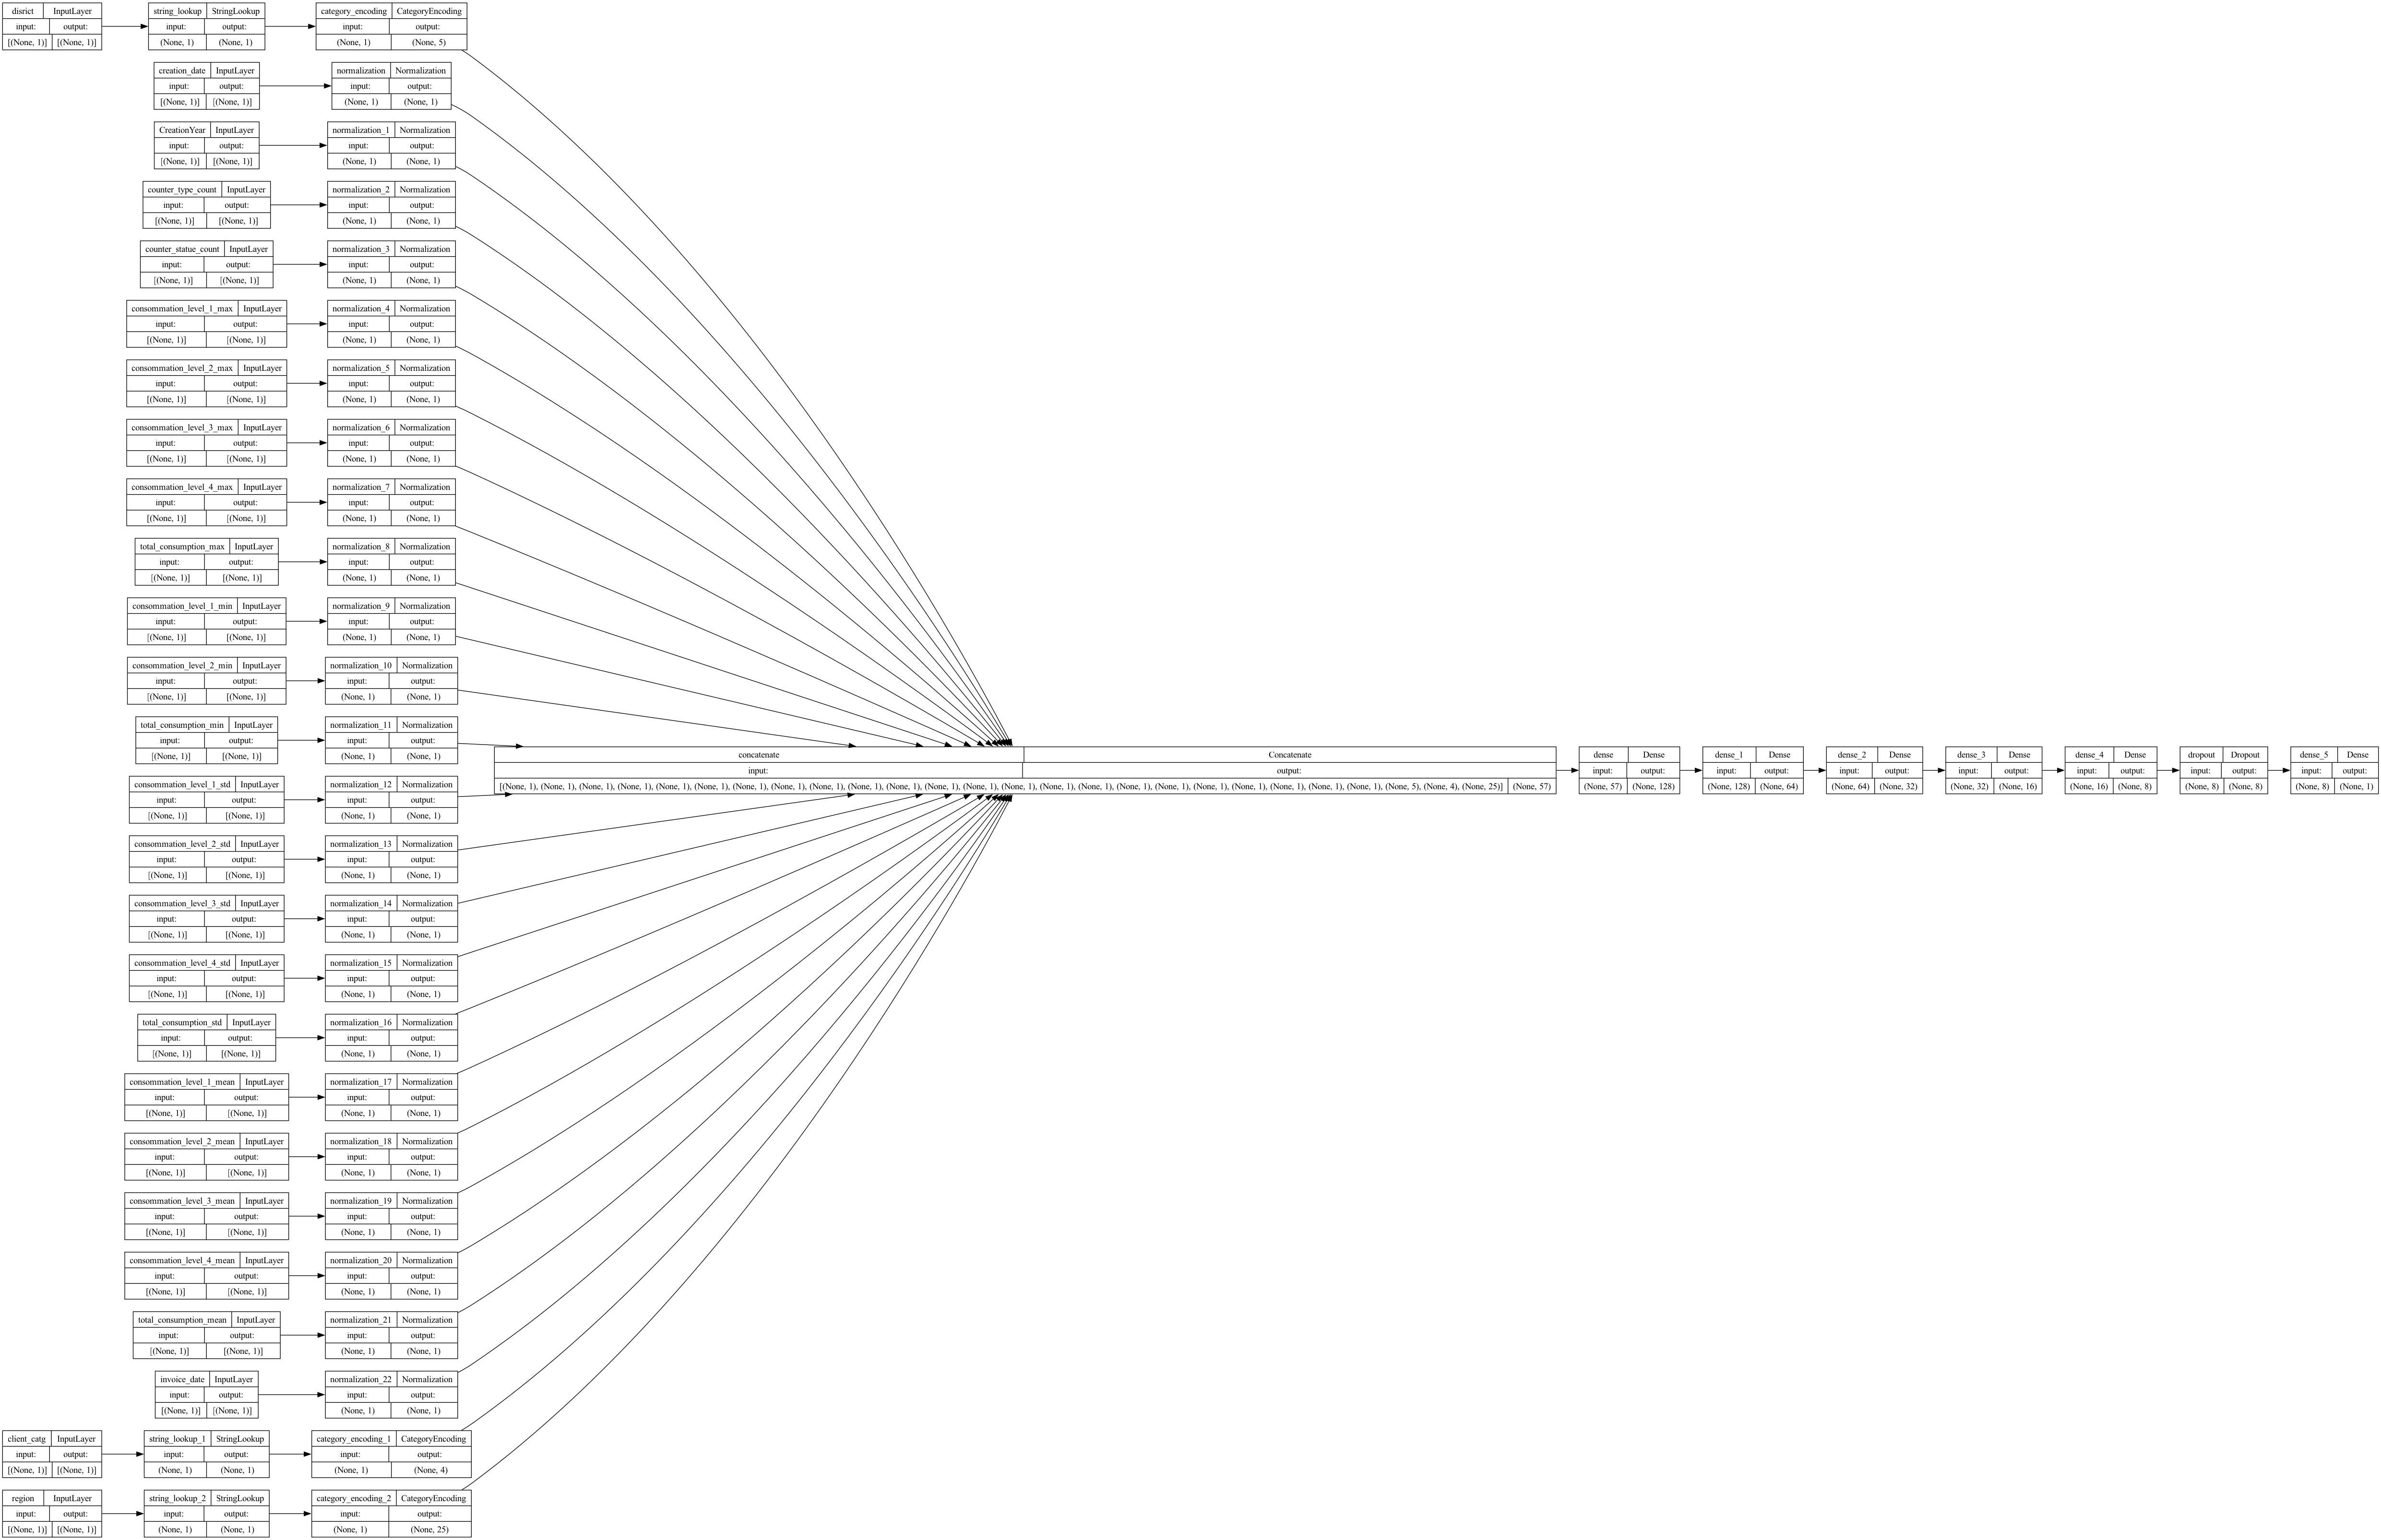

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Compile and run model. 

In [24]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["AUC"])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 disrict (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 client_catg (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 region (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 creation_date (InputLayer)  [(None, 1)]                  0         []                            
                                                                                              

In [26]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
206/206 [==============================] - 2s 3ms/step - loss: 0.2133 - auc: 0.6463 - val_loss: 0.2070 - val_auc: 0.7254
Epoch 2/50
206/206 [==============================] - 1s 3ms/step - loss: 0.2053 - auc: 0.7117 - val_loss: 0.2046 - val_auc: 0.7397
Epoch 3/50
206/206 [==============================] - 1s 3ms/step - loss: 0.2040 - auc: 0.7202 - val_loss: 0.2010 - val_auc: 0.7508
Epoch 4/50
206/206 [==============================] - 1s 3ms/step - loss: 0.2019 - auc: 0.7315 - val_loss: 0.2002 - val_auc: 0.7549
Epoch 5/50
206/206 [==============================] - 1s 3ms/step - loss: 0.2009 - auc: 0.7355 - val_loss: 0.1992 - val_auc: 0.7583
Epoch 6/50
206/206 [==============================] - 1s 3ms/step - loss: 0.2005 - auc: 0.7381 - val_loss: 0.1978 - val_auc: 0.7645
Epoch 7/50
206/206 [==============================] - 1s 3ms/step - loss: 0.1993 - auc: 0.7458 - val_loss: 0.1965 - val_auc: 0.7656
Epoch 8/50
206/206 [==============================] - 1s 3ms/step - loss: 0.

In [27]:
def df_to_dataset_testing(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  df = {key: np.array(value)[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df)))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [28]:
test_dataset = df_to_dataset_testing(test_data, shuffle = False, batch_size = 512)

In [29]:
prediction = model.predict(test_dataset)

114/114 [==============================] - 0s 3ms/step


In [30]:
sample_submission["target"] = prediction
sample_submission["target"] = pd.DataFrame.fillna(sample_submission["target"], value = 0)
sample_submission.to_csv(f'{OUTPUT_DIR}/result.csv')